In [101]:
import math
import random
import pandas
import seaborn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn.dense import Linear
from torch_geometric.nn import GCNConv, pool
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader

In [102]:
""" Create dataste of Pytorch Geometric Data objects """

nnodes = 100
nnfeature = 1
nefeatures = 1
dataset = []

for _ in range(2000):
    # undirected graph contains edges in both direcitons
    source_nodes, target_nodes = [], []
    edge_weights = []
    for i in range(1, nnodes+1):
        source_nodes += [(i-1) % nnodes, i % nnodes]
        target_nodes += [i % nnodes, (i-1) % nnodes]
        weight = random.uniform(-1, 1)
        edge_weights += [weight, weight]

    x = torch.tensor([[random.choice([-1, 1])] for _ in range(nnodes)], dtype=torch.float)
    edge_index = torch.LongTensor([source_nodes, target_nodes])
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)

    # calculate resulting energy of the lattice
    energy = 0
    for i in range(1, nnodes):
        energy += x[i-1][0] * x[i][0] * edge_weights[(i-1)*2]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights, y=energy/(nnodes*5))
    dataset.append(data)

# check if edges are encoded correctly
for data in dataset:
    assert data.edge_index.max() < data.num_nodes

In [103]:
""" 
Splitting and batching the dataset 

A data loader which merges data objects from a 
torch_geometric.data.Dataset to a mini-batch. 
Data objects can be either of type Data or HeteroData.
"""


split = (len(dataset) // 10) * 2
train_dataset = dataset[split:]
test_dataset = dataset[:split]


train_loader = DataLoader(train_dataset, shuffle=True, batch_size=10)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=5)
print(f"Number of training graphs: {len(train_loader)}")
print(f"Number of testing graphs: {len(test_loader)}")

Number of training graphs: 160
Number of testing graphs: 80


/home/benb/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


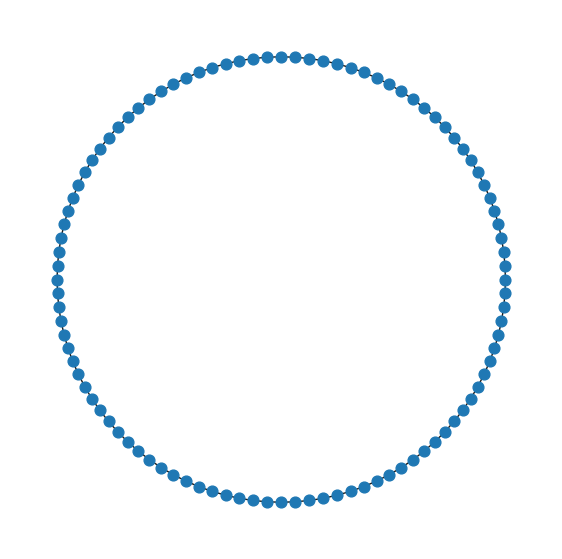

In [104]:
def visualize_graph(G):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_circular(G, cmap="Set2", node_size=60,font_size=8)
    plt.show()

graph = dataset[0]
G = to_networkx(graph, to_undirected=True)
visualize_graph(G)


In [105]:
""" Architecture of the neural network """

class GraphNetRegression(torch.nn.Module):
    def __init__(self, num_node_features, num_output_features):
        super(GraphNetRegression, self).__init__()
        self.conv1 = GCNConv(num_node_features, 8, improved=True)
        self.conv2 = GCNConv(8, 8, improved=True)
        self.fc = nn.Linear(8, num_output_features)

    def forward(self, x, edge_index, edge_weighs, batch):
        x = self.conv1(x, edge_index, edge_weighs)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index, edge_weighs)
        x = F.relu(x)
        x = self.fc(x)
        x = pool.global_mean_pool(x, batch)
        
        x = x.flatten()
        return x


In [106]:
num_node_features = 1
num_output_features = 1
model = GraphNetRegression(num_node_features, num_output_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def train():
    model.train()
    # Iterate in batches over the training dataset.
    for data in train_loader:
        # Perform a single forward pass.
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = F.mse_loss(out, data.y) 
        
        # Derive gradients
        loss.backward()
        
        # Update parameters based on gradients.
        optimizer.step()
        optimizer.zero_grad()

def test(loader, epoch):
     model.eval()
     mse_loss = 0
     for data in loader:
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)  
        loss = F.mse_loss(out, data.y) 
        mse_loss += loss
     return float(mse_loss)

In [107]:
""" Model parameters """

print(model)
print("Trainable parameters of the model:")
for p in model.parameters():
    if p.requires_grad: print('\t', p.shape)
print("Sum of parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

GraphNetRegression(
  (conv1): GCNConv(1, 8)
  (conv2): GCNConv(8, 8)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)
Trainable parameters of the model:
	 torch.Size([8])
	 torch.Size([8, 1])
	 torch.Size([8])
	 torch.Size([8, 8])
	 torch.Size([1, 8])
	 torch.Size([1])
Sum of parameters:  97


Epoch: 000, Train Loss: 0.87521, Test Loss: 0.43656
Epoch: 001, Train Loss: 0.25231, Test Loss: 0.12536
Epoch: 002, Train Loss: 0.06255, Test Loss: 0.03067
Epoch: 003, Train Loss: 0.03312, Test Loss: 0.01603
Epoch: 004, Train Loss: 0.03093, Test Loss: 0.01495
Epoch: 005, Train Loss: 0.03052, Test Loss: 0.01474
Epoch: 006, Train Loss: 0.03017, Test Loss: 0.01457
Epoch: 007, Train Loss: 0.02981, Test Loss: 0.01438
Epoch: 008, Train Loss: 0.02946, Test Loss: 0.01419
Epoch: 009, Train Loss: 0.02910, Test Loss: 0.01400
Epoch: 010, Train Loss: 0.02870, Test Loss: 0.01380
Epoch: 011, Train Loss: 0.02827, Test Loss: 0.01357
Epoch: 012, Train Loss: 0.02785, Test Loss: 0.01335
Epoch: 013, Train Loss: 0.02742, Test Loss: 0.01313
Epoch: 014, Train Loss: 0.02703, Test Loss: 0.01293
Epoch: 015, Train Loss: 0.02656, Test Loss: 0.01269
Epoch: 016, Train Loss: 0.02636, Test Loss: 0.01260
Epoch: 017, Train Loss: 0.02573, Test Loss: 0.01227
Epoch: 018, Train Loss: 0.02529, Test Loss: 0.01203
Epoch: 019, 

Text(0, 0.5, 'MSE loss')

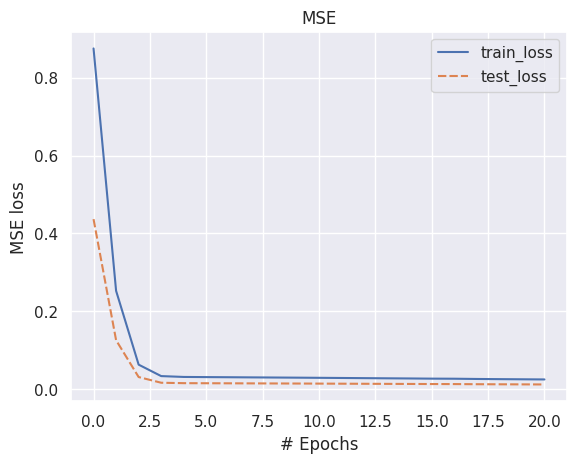

In [108]:
epoch = 20
train_loss, test_loss = [], []
for epoch in range(epoch+1):
    train()
    train_loss.append(test(train_loader, epoch))
    test_loss.append(test(test_loader, epoch))
    # wandb.log({"acc": train_loss[-1], "loss": test_loss[-1]})
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss[-1]:.5f}, Test Loss: {test_loss[-1]:.5f}')

loss_df = pandas.DataFrame({'epochs': range(epoch+1), 'train_loss': train_loss, 'test_loss': test_loss})

seaborn.set_theme()
loss_plot = seaborn.lineplot(loss_df[['train_loss', 'test_loss']])
# loss_plot = seaborn.lineplot(test_loss)
loss_plot.set_title("MSE")
loss_plot.set_xlabel("# Epochs")
loss_plot.set_ylabel("MSE loss")

Text(0.5, 1.0, 'Frequency of loss')

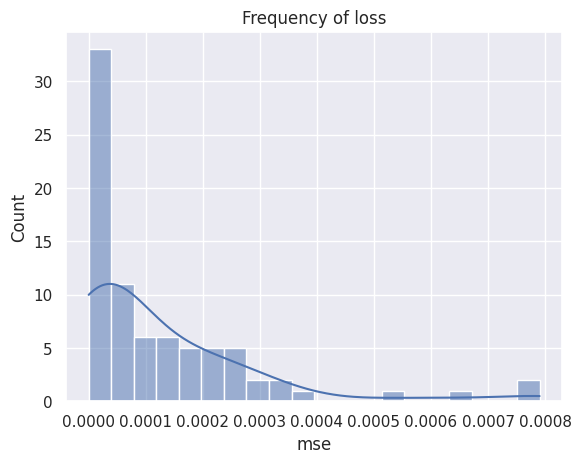

In [109]:
pred_df = pandas.DataFrame(columns=['pred', 'y_true', 'mse'])
model.eval()
for idx, data in enumerate(test_loader):
    out = model(data.x, data.edge_index, data.edge_weight, data.batch)
    for i in range(len(out)):
        pred_df.loc[idx] = [float(out[i]), float(data.y[i]), float(F.mse_loss(out[i], data.y[i]))]

loss_freq_plot = seaborn.histplot(pred_df['mse'], bins=20, kde=True)
loss_freq_plot.set_title("Frequency of loss")

Text(0.5, 1.0, 'mse depending on value of the prediciton')

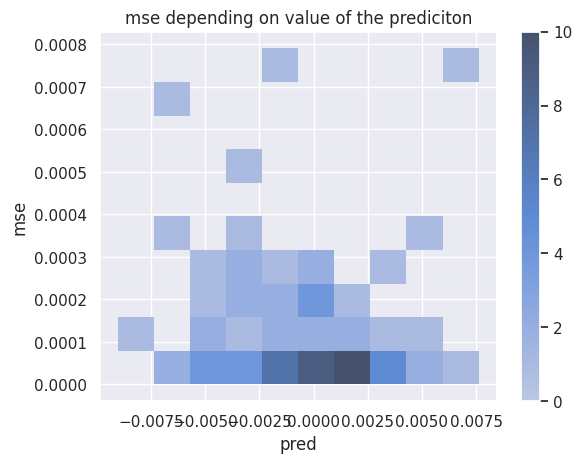

In [110]:
loss_val_plot = seaborn.histplot(data=pred_df['mse'], x=pred_df['pred'], y=pred_df['mse'], bins=10, cbar=True)
loss_val_plot.set_title("mse depending on value of the prediciton")